In [2]:
import json
import pandas as pd
from fnmatch import fnmatch
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import chi2

### Reddit Data

In [14]:
def read_jsonl_to_dataframe(file_path):
    rows = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if line.strip():
                try:
                    rows.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
    return pd.DataFrame(rows)

In [15]:
abortion_raw = read_jsonl_to_dataframe("data/Abortiondebate_submissions")
vaccines_raw = read_jsonl_to_dataframe("data/CovidVaccinated_submissions")
israel_raw = read_jsonl_to_dataframe("data/IsraelPalestine_submissions")
neutral_raw = read_jsonl_to_dataframe("data/NeutralPolitics_submissions")

In [7]:
datasets = {"abortion": abortion_raw,"vaccines": vaccines_raw,"israel": israel_raw,"neutral": neutral_raw}

for name,df in datasets.items():

    # Preprocessing
    df = df.dropna(subset=["selftext"])
    df = df[~df["selftext"].str.strip().isin(["[removed]", "[deleted]", ""])]
    df = df[~df["selftext"].str.strip().str.startswith("[View Poll]")]
    df = df[~df["selftext"].str.strip().str.match(r'^https?://\S+$')]
    df = df[~df["selftext"].str.strip().str.match(r'^\d+$')]
    df = df[df["stickied"]==False]

    # Selection of relevant variables
    df = df[["author","title","selftext","num_comments","score"]]
    
    datasets[name] = df

In [12]:
abortion_df = datasets["abortion"]
vaccines_df = datasets["vaccines"]
israel_df = datasets["israel"]
neutral_df = datasets["neutral"]

### LIWC Dictionaries

In [13]:
with open("data/emo_dict.txt", "r", encoding="utf-8") as f:
    emo_dict = f.read().replace("\n", "").split(",")
    emo_dict= [w.strip().strip('"') for w in emo_dict if w.strip()]

with open("data/moral_dict.txt", "r", encoding="utf-8") as f:
    moral_dict = f.read().replace("\n", "").split(",")
    moral_dict= [w.strip().strip('"') for w in moral_dict if w.strip()]

with open("data/moral_emo_dict.txt", "r", encoding="utf-8") as f:
    moral_emo_dict = f.read().replace("\n", "").split(",")
    moral_emo_dict= [w.strip().strip('"') for w in moral_emo_dict if w.strip()]

In [14]:
def tokenize(text):
    text = text.lower().replace(".","").replace("!","").replace("?","").replace(":","").replace(",","").split()
    return text

In [15]:
def count_dict_tokens(tokens,dict):
    count = 0
    for token in tokens:
        for word in dict:
            if fnmatch(token,word):
                count += 1
                break
    return count

In [ ]:
for name,df in datasets.items():
    df["tokens"] = df["selftext"].apply(tokenize)
    
    emo_counts = []
    moral_counts = []
    moral_emo_counts = []

    for tokens in tqdm(df["tokens"],desc=f"Processing {name}"):
        count_emo = count_dict_tokens(tokens, emo_dict)
        count_moral = count_dict_tokens(tokens, moral_dict)
        count_moral_emo = count_dict_tokens(tokens, moral_emo_dict)

        emo_counts.append(count_emo)
        moral_counts.append(count_moral)
        moral_emo_counts.append(count_moral_emo)

    df["emo_count"] = emo_counts
    df["moral_count"] = moral_counts
    df["moral_emo_count"] = moral_emo_counts

    datasets[name] = df

Processing neutral: 100%|██████████| 4886/4886 [20:51<00:00,  3.90it/s] 


In [ ]:
#abortion_df.to_csv("data/abortion.csv")
#vaccines_df.to_csv("data/vaccines.csv")
#israel_df.to_csv("data/israel.csv")
#neutral_df.to_csv("data/neutral.csv")

### Main Data Analysis (Negative Binomial Regression)

In [37]:
abortion_df = pd.read_csv("data/abortion.csv",index_col=0)
vaccines_df = pd.read_csv("data/vaccines.csv",index_col=0)
israel_df = pd.read_csv("data/israel.csv",index_col=0)
neutral_df = pd.read_csv("data/neutral.csv",index_col=0)

datasets = {"abortion": abortion_df,"vaccines": vaccines_df,"israel": israel_df,"neutral": neutral_df}

In [38]:
# Control Variable (Length of Submission)
for name,df in datasets.items():
    df["token_count"] = df["tokens"].str.len()
    datasets[name] = df

In [6]:
results = []

for name, df in datasets.items():
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const", "emo_count", "moral_count", "moral_emo_count", "token_count"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})

### Visualisierung

#### Tables

In [7]:
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["emo_count", "moral_count", "moral_emo_count", "token_count", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)

#### Plots

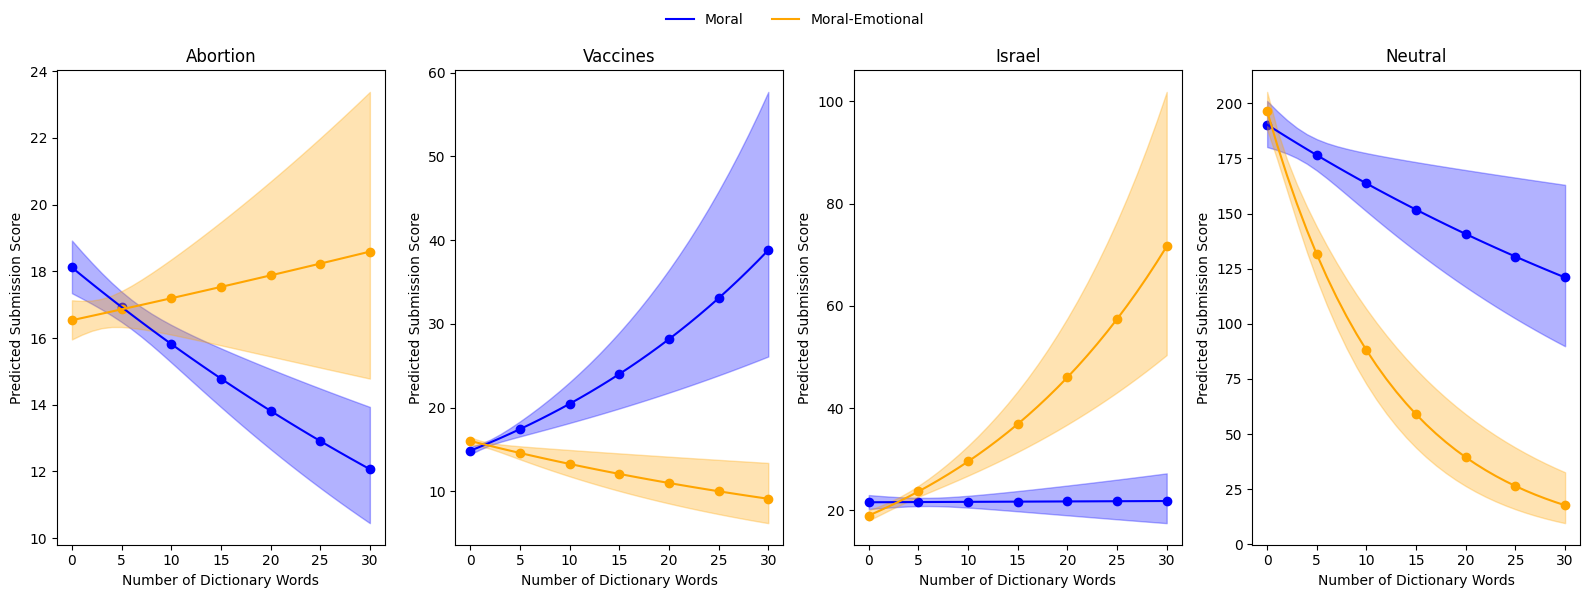

In [8]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

fig, axes = plt.subplots(1, 4, figsize=(16, 6)) 
for ax, (name, df) in zip(axes, datasets.items()):
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X).fit(disp=0)

    mean_vals = df[["emo_count", "moral_count", "moral_emo_count", "token_count"]].mean()

    moral_range = np.arange(0, 31)
    moral_emo_range = np.arange(0, 31)

    df_pred = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": moral_range,
        "moral_emo_count": mean_vals["moral_emo_count"],
        "token_count": mean_vals["token_count"]})
    df_pred_moemo = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": moral_emo_range,
        "token_count": mean_vals["token_count"]})

    X_pred_scaled = scaler.transform(df_pred)
    X_pred = sm.add_constant(X_pred_scaled)
    X_pred_emo_scaled = scaler.transform(df_pred_moemo)
    X_pred_emo = sm.add_constant(X_pred_emo_scaled)

    pred = model.get_prediction(X_pred, transform=True).summary_frame()
    pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()

    ax.plot(moral_range, pred["predicted"], label="Moral", color="blue")
    ax.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
    indices = np.arange(0, len(moral_range), 5)
    ax.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

    ax.plot(moral_emo_range, pred_emo["predicted"], label="Moral-Emotional", color="orange")
    ax.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
    indices = np.arange(0, len(moral_emo_range), 5)
    ax.scatter(moral_emo_range[indices], pred_emo["predicted"].iloc[indices], color="orange")

    ax.set_xlabel("Number of Dictionary Words")
    ax.set_ylabel("Predicted Submission Score")
    ax.set_title(name.capitalize())

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


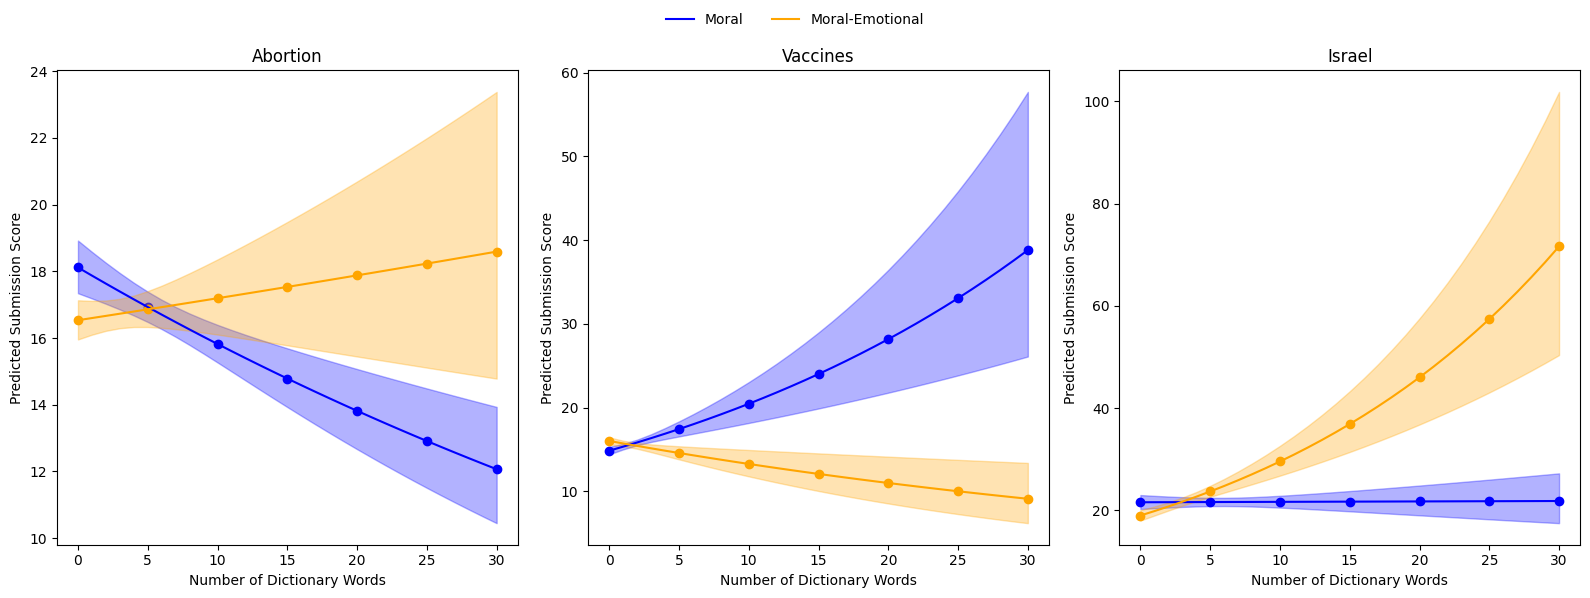

In [9]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

fig, axes = plt.subplots(1, 3, figsize=(16, 6)) 
for ax, (name, df) in zip(axes, list(datasets.items())[:-1]):
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X).fit(disp=0)

    mean_vals = df[["emo_count", "moral_count", "moral_emo_count", "token_count"]].mean()

    moral_range = np.arange(0, 31)
    moral_emo_range = np.arange(0, 31)

    df_pred = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": moral_range,
        "moral_emo_count": mean_vals["moral_emo_count"],
        "token_count": mean_vals["token_count"]})
    df_pred_moemo = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": moral_emo_range,
        "token_count": mean_vals["token_count"]})

    X_pred_scaled = scaler.transform(df_pred)
    X_pred = sm.add_constant(X_pred_scaled)
    X_pred_emo_scaled = scaler.transform(df_pred_moemo)
    X_pred_emo = sm.add_constant(X_pred_emo_scaled)

    pred = model.get_prediction(X_pred, transform=True).summary_frame()
    pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()

    ax.plot(moral_range, pred["predicted"], label="Moral", color="blue")
    ax.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
    indices = np.arange(0, len(moral_range), 5)
    ax.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

    ax.plot(moral_emo_range, pred_emo["predicted"], label="Moral-Emotional", color="orange")
    ax.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
    indices = np.arange(0, len(moral_emo_range), 5)
    ax.scatter(moral_emo_range[indices], pred_emo["predicted"].iloc[indices], color="orange")

    ax.set_xlabel("Number of Dictionary Words")
    ax.set_ylabel("Predicted Submission Score")
    ax.set_title(name.capitalize())

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


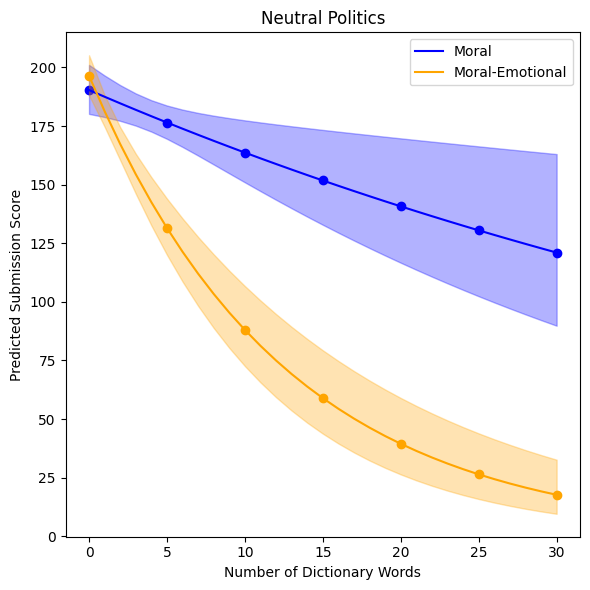

In [10]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

neutral_df = neutral_df[neutral_df["token_count"] <= 10000].copy()
y = neutral_df["score"].values

scaler = StandardScaler()
x = scaler.fit_transform(neutral_df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
X = sm.add_constant(x)

model = NegativeBinomial(y, X).fit(disp=0)
mean_vals = neutral_df[["emo_count", "moral_count", "moral_emo_count", "token_count"]].mean()

moral_range = np.arange(0, 31)
moral_emo_range = np.arange(0, 31)

df_pred = pd.DataFrame({
    "emo_count": mean_vals["emo_count"],
    "moral_count": moral_range,
    "moral_emo_count": mean_vals["moral_emo_count"],
    "token_count": mean_vals["token_count"]})
df_pred_moemo = pd.DataFrame({
    "emo_count": mean_vals["emo_count"],
    "moral_count": mean_vals["moral_count"],
    "moral_emo_count": moral_emo_range,
    "token_count": mean_vals["token_count"]})

X_pred = sm.add_constant(scaler.transform(df_pred))
X_pred_emo = sm.add_constant(scaler.transform(df_pred_moemo))

pred = model.get_prediction(X_pred, transform=True).summary_frame()
pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()

plt.figure(figsize=(6, 6))
plt.plot(moral_range, pred["predicted"], label="Moral", color="blue")
plt.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
indices = np.arange(0, len(moral_range), 5)
plt.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

plt.plot(moral_emo_range, pred_emo["predicted"], label="Moral-Emotional", color="orange")
plt.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
indices = np.arange(0, len(moral_emo_range), 5)
plt.scatter(moral_emo_range[indices], pred_emo["predicted"].iloc[indices], color="orange")

plt.xlabel("Number of Dictionary Words")
plt.ylabel("Predicted Submission Score")
plt.title("Neutral Politics")

plt.legend()
plt.tight_layout()
plt.show()


### Robustness Tests

#### Negative Binomial vs. Poisson Regression (check for Overdispersion)

In [19]:
for name, df in datasets.items():
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
    X = sm.add_constant(x)

    # Negative Binomial Model
    model_nb = NegativeBinomial(y, X)
    result_nb = model_nb.fit(disp=0)
    ll_nb = result_nb.llf

    # Poisson Model 
    model_pois = sm.GLM(y, X, family=sm.families.Poisson())
    result_pois = model_pois.fit()
    ll_pois = result_pois.llf

    # Likelihood Ratio Test
    LR = 2 * (ll_nb - ll_pois)
    p_value = chi2.sf(LR, df = 1)

    print(f"""LR-Test statistic between NB-Model and Poisson Model for the dataset '{name.capitalize()}' is {LR:.2f}.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: {p_value:.2f}\n""")

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Abortion' is 86900.94.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.00

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Vaccines' is 371477.92.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.00

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Israel' is 189575.63.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.00

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Neutral' is 1319061.15.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.00



p-value < 0.05 suggests overdispersion in the data. In this case a Negative-Binomial Model outperforms a Poisson Model signficantly.
As all four datasets seems to show significant signs of overdispersion, the use of a NB-Model over a Poisson Model is valid.

#### Plot all 3 three models

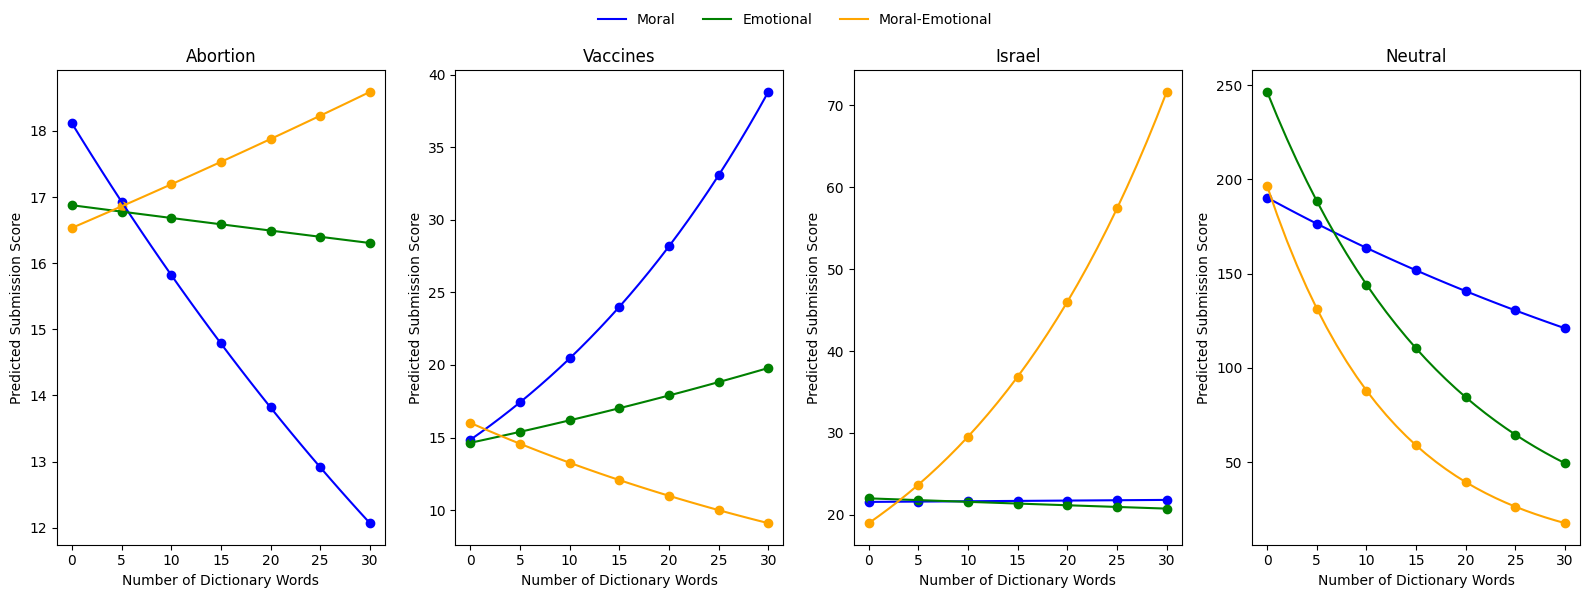

In [17]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

fig, axes = plt.subplots(1, 4, figsize=(16, 6)) 
for ax, (name, df) in zip(axes, datasets.items()):
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X).fit(disp=0)

    mean_vals = df[["emo_count", "moral_count", "moral_emo_count", "token_count"]].mean()

    moral_range = np.arange(0, 31)
    emo_range = np.arange(0,31)
    moral_emo_range = np.arange(0, 31)

    df_pred = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": moral_range,
        "moral_emo_count": mean_vals["moral_emo_count"],
        "token_count": mean_vals["token_count"]})
    df_pred_emo = pd.DataFrame({
        "emo_count": emo_range,
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": mean_vals["moral_emo_count"],
        "token_count": mean_vals["token_count"]})
    df_pred_moemo = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": moral_emo_range,
        "token_count": mean_vals["token_count"]})

    X_pred_scaled = scaler.transform(df_pred)
    X_pred = sm.add_constant(X_pred_scaled)
    X_pred_emo_scaled = scaler.transform(df_pred_emo)
    X_pred_emo = sm.add_constant(X_pred_emo_scaled)
    X_pred_moemo_scaled = scaler.transform(df_pred_moemo)
    X_pred_moemo = sm.add_constant(X_pred_moemo_scaled)

    pred = model.get_prediction(X_pred, transform=True).summary_frame()
    pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()
    pred_moemo = model.get_prediction(X_pred_moemo, transform=True).summary_frame()

    ax.plot(moral_range, pred["predicted"], label="Moral", color="blue")
    #ax.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
    indices = np.arange(0, len(moral_range), 5)
    ax.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

    ax.plot(emo_range, pred_emo["predicted"], label="Emotional", color="green")
    #ax.fill_between(emo_range, pred["ci_lower"], pred["ci_upper"], color="green", alpha=0.3)
    indices = np.arange(0, len(emo_range), 5)
    ax.scatter(emo_range[indices], pred_emo["predicted"].iloc[indices], color="green")

    ax.plot(moral_emo_range, pred_moemo["predicted"], label="Moral-Emotional", color="orange")
    #ax.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
    indices = np.arange(0, len(moral_emo_range), 5)
    ax.scatter(moral_emo_range[indices], pred_moemo["predicted"].iloc[indices], color="orange")

    ax.set_xlabel("Number of Dictionary Words")
    ax.set_ylabel("Predicted Submission Score")
    ax.set_title(name.capitalize())

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Independence of Models (incl. Bootstrapping)

In [39]:
np.random.seed(1)
coef_dict = {}

for name, df in datasets.items():
    sample_df = df[df["token_count"] <= 10000].copy()

    user_counts = sample_df["author"].value_counts()
    multi_submission_users = user_counts[user_counts > 1].index
    sample_df = sample_df[sample_df["author"].isin(multi_submission_users)].copy()

    coef_dict[name] = {key: [] for key in ["emo_count", "moral_count", "moral_emo_count"]}

    for i in range(1,10001):
        sample = sample_df.sample(1000,replace=True)
        
        y = sample["score"].values
        scaler = StandardScaler()
        x = scaler.fit_transform(sample[["emo_count", "moral_count", "moral_emo_count", "token_count"]])
        X = sm.add_constant(x)

        model = NegativeBinomial(y, X)
        result = model.fit(disp=0)
        param_names = ["emo_count", "moral_count", "moral_emo_count"]
        columns = ["const"] + param_names + ["token_count"]
        params_named = dict(zip(columns, result.params))
        for param in param_names:
            coef_dict[name][param].append(params_named[param])

with open("data/bootstrap_data.json", "w") as f:
    json.dump(coef_dict, f)

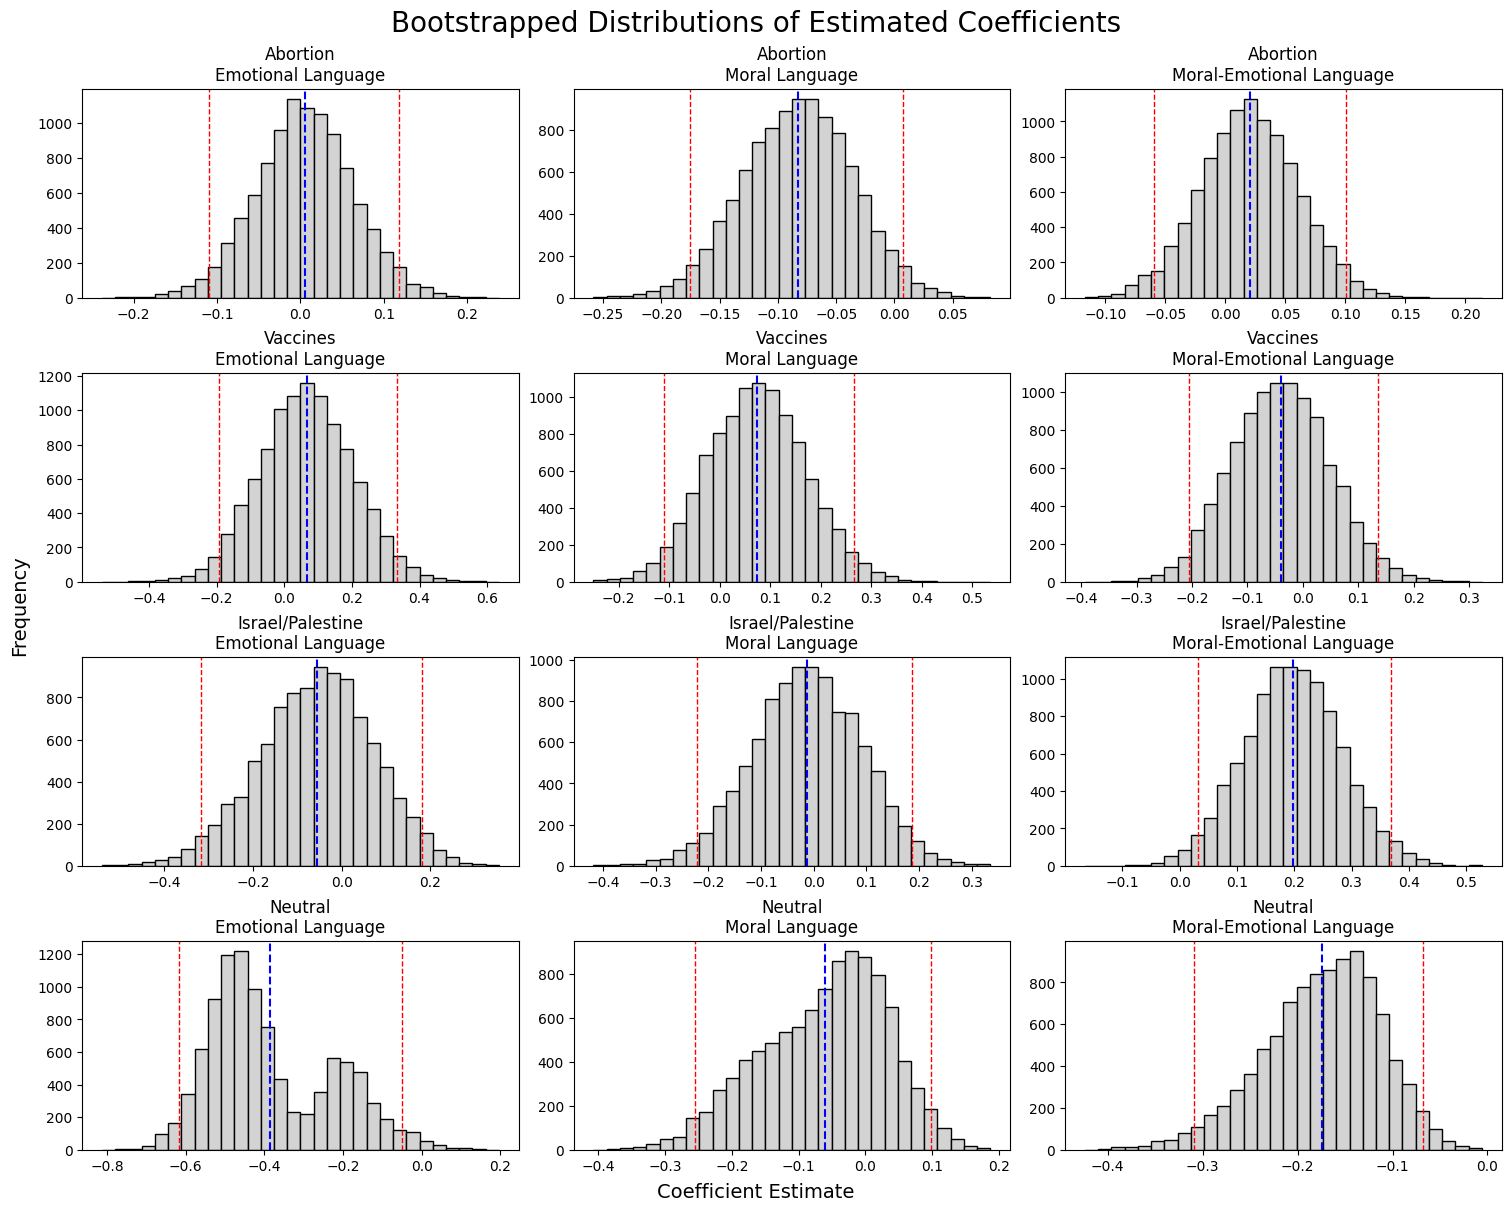

In [40]:
bootstrap_data = pd.read_json("data/bootstrap_data.json")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), constrained_layout=True)

df_names = ["abortion", "vaccines", "israel", "neutral"]
predictors = ["emo_count", "moral_count", "moral_emo_count"]
predictor_labels = ["Emotional Language", "Moral Language", "Moral-Emotional Language"]
dataset_labels = ["Abortion", "Vaccines", "Israel/Palestine", "Neutral"]

for index, dataset in enumerate(df_names):
    for jndex, predictor in enumerate(predictors):
        ax = axes[index, jndex]
        coefs = bootstrap_data[dataset][predictor]
        ax.hist(coefs, bins=30, color='lightgrey', edgecolor='black')

        mean = np.mean(coefs)
        lower = np.percentile(coefs, 2.5)
        upper = np.percentile(coefs, 97.5)

        ax.axvline(mean, color='blue', linestyle='--', linewidth=1.5)
        ax.axvline(lower, color='red', linestyle='--', linewidth=1)
        ax.axvline(upper, color='red', linestyle='--', linewidth=1)

        ax.set_title(f"{dataset_labels[index]}\n{predictor_labels[jndex]}", fontsize=12)

plt.suptitle("Bootstrapped Distributions of Estimated Coefficients", fontsize=20)
fig.supxlabel("Coefficient Estimate", fontsize=14)
fig.supylabel("Frequency", fontsize=14)
plt.show()


### Other Models

In [ ]:
# Without Control
results = []

for name, df in datasets.items():
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const", "emo_count", "moral_count", "moral_emo_count", "token_count"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})
    
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["emo_count", "moral_count", "moral_emo_count", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)

In [ ]:
# Just moral-emotional
results = []

for name, df in datasets.items():
    df = df[df["token_count"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["moral_emo_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const","moral_emo_count"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})
    
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["moral_emo_count", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)